# UK Government COVID Vaccines Analysis
The UK government is launching a marketing campaign to promote the vaccine. To support the campaign this analysis will uncover the following insights and information:
- What the total vaccinations (first dose, second dose per region, total and overtime) are.
- Where the first marketing campaigns should be targetted
- Whether there has been a lot of interest about COVID on twitter
- Which regions are yet to experience a surge in hospitalisations 

The notebook will be divided into three parts:
- Part 1 will answer the first two questions
- Part 2 will analyse the twitter data
- Part 3 will explore where there may be a surge in hospiltalisation

### GitHub Repository
Insert URL (to your public GitHub repository) and a screenshot - double click cell to edit
- [My Github Repo](https://github.com/username/reponame)
- Screenshot demo (replace with your own).

!['My Github screenshot](http://github.com/apvoges/lse-ca/blob/main/GitHubScreenshot.png?raw=true)
(Note that this only works if your repo is set to **public**. Alternatively you need to refer to a local image and include this image in your submission.)

### Setting up the Environment

In [229]:
# Importing the required libraries and setting the plotting options
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,10)})

## Part 1 - Covid Cases and Vaccinations

#### Importing and Exploring Datasets to answer the governments questions 

In [230]:
# Importing the Covid Cases and Vaccines Datasets  
cov = pd.read_csv('covid_19_uk_cases.csv')
vac = pd.read_csv('covid_19_uk_vaccinated.csv')

In [231]:
# Exploring the Covid Cases Dataframe
print(cov.shape)
print(cov.dtypes)
print(cov.head())
print(cov.tail())

(7584, 12)
Province/State               object
Country/Region               object
Lat                         float64
Long                        float64
ISO 3166-1 Alpha 3-Codes     object
Sub-region Name              object
Intermediate Region Code      int64
Date                         object
Deaths                      float64
Cases                       float64
Recovered                   float64
Hospitalised                float64
dtype: object
  Province/State  Country/Region      Lat     Long ISO 3166-1 Alpha 3-Codes  \
0       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
1       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
2       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
3       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
4       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   

                   Sub-region Name  Intermediate Region Code        

In [6]:
# Exploring the Vaccine Dataframe
print(vac.shape)
print(vac.dtypes)
print(vac.head())
print(vac.tail())

(7584, 11)
Province/State               object
Country/Region               object
Lat                         float64
Long                        float64
ISO 3166-1 Alpha 3-Codes     object
Sub-region Name              object
Intermediate Region Code      int64
Date                         object
Vaccinated                    int64
First Dose                    int64
Second Dose                   int64
dtype: object
  Province/State  Country/Region      Lat     Long ISO 3166-1 Alpha 3-Codes  \
0       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
1       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
2       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
3       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
4       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   

                   Sub-region Name  Intermediate Region Code        Date  \
0  Latin America and the Car

#### Merging and Cleaning Dataframes
Both dataframes have the same number of rows, and the first 8 columns are identical. 
To help with future analysis both dataframes will be merged

In [9]:
# Outerjoin Cov and Vac Dataframes
covvac_full = pd.merge(cov, vac, how = 'outer')
print(covvac_full.shape)
print(covvac_full.dtypes)
print(covvac_full.head())

(7584, 15)
Province/State               object
Country/Region               object
Lat                         float64
Long                        float64
ISO 3166-1 Alpha 3-Codes     object
Sub-region Name              object
Intermediate Region Code      int64
Date                         object
Deaths                      float64
Cases                       float64
Recovered                   float64
Hospitalised                float64
Vaccinated                    int64
First Dose                    int64
Second Dose                   int64
dtype: object
  Province/State  Country/Region      Lat     Long ISO 3166-1 Alpha 3-Codes  \
0       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
1       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
2       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
3       Anguilla  United Kingdom  18.2206 -63.0686                      AIA   
4       Anguilla  United Kingdom  18.220

In [12]:
# Deleting redundant columns
covvac = covvac_full[[ 'Province/State', 'Date', 'Deaths', 'Cases', 'Recovered', 'Hospitalised',
                      'Vaccinated', 'First Dose', 'Second Dose']]
covvac.dtypes

Province/State     object
Date               object
Deaths            float64
Cases             float64
Recovered         float64
Hospitalised      float64
Vaccinated          int64
First Dose          int64
Second Dose         int64
dtype: object

In [291]:
# Changing Date datatype to datetime
# Ignore Jupyter warning
covvac['Date'] = pd.to_datetime(covvac['Date'], format='%Y-%m-%d')
print(covvac.dtypes)

Province/State            object
Date              datetime64[ns]
Deaths                   float64
Cases                    float64
Recovered                float64
Hospitalised             float64
Vaccinated                 int64
First Dose                 int64
Second Dose                int64
DateMonth                 object
dtype: object


/var/folders/vm/m0mbrqn92kndn3vy7sxnktpm0000gn/T/ipykernel_39373/690700845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covvac['Date'] = pd.to_datetime(covvac['Date'], format='%Y-%m-%d')


#### Finding and Correcting Missing Data

In [16]:
# Checking for Missing Data
covvac.isnull().sum()

Province/State    0
Date              0
Deaths            2
Cases             2
Recovered         2
Hospitalised      2
Vaccinated        0
First Dose        0
Second Dose       0
dtype: int64

In [17]:
# Finding rows with missing data
rows_with_nan = []

for index, row in cov.iterrows():
    is_nan_series = row.isnull()

    if is_nan_series.any():
        rows_with_nan.append(index)

print(rows_with_nan)

[875, 876]


In [18]:
# Printing rows with missing data
covvac [874: 878]

,Province/State,Date,Deaths,Cases,Recovered,Hospitalised,Vaccinated,First Dose,Second Dose
874,Bermuda,2020-09-20,9.0,180.0,166.0,84.0,0,0,0
875,Bermuda,2020-09-21,NaN,NaN,NaN,NaN,0,0,0
876,Bermuda,2020-09-22,NaN,NaN,NaN,NaN,0,0,0
877,Bermuda,2020-09-23,9.0,181.0,167.0,104.0,0,0,0


In [31]:
# Forwardfilling rows with missing data
# Ignore Jupyter warning

covvac ['Deaths'] = covvac ['Deaths'] .fillna (method = 'ffill')
covvac ['Cases'] = covvac ['Cases'].fillna (method = 'ffill')
covvac ['Recovered'] = covvac ['Recovered'].fillna (method = 'ffill')
covvac ['Hospitalised'] = covvac ['Hospitalised'].fillna (method = 'ffill')

/var/folders/vm/m0mbrqn92kndn3vy7sxnktpm0000gn/T/ipykernel_39373/1770951472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covvac ['Deaths'] = covvac ['Deaths'] .fillna (method = 'ffill')
/var/folders/vm/m0mbrqn92kndn3vy7sxnktpm0000gn/T/ipykernel_39373/1770951472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covvac ['Cases'] = covvac ['Cases'].fillna (method = 'ffill')
/var/folders/vm/m0mbrqn92kndn3vy7sxnktpm0000gn/T/ipykernel_39373/1770951472.py:6: SettingWithCopyWarning: 
A value is trying to b

In [30]:
# Checking for Missing Data
covvac.isnull().sum()

Province/State    0
Date              0
Deaths            0
Cases             0
Recovered         0
Hospitalised      0
Vaccinated        0
First Dose        0
Second Dose       0
dtype: int64

#### Exploring Data of a Single Region to understand how variables change over time

In [54]:
#Create Dataframe with only Gibraltar Data
#Gibraltar chosen at random
gibraltar = covvac [covvac['Province/State'] == 'Gibraltar']

#Print complete Dataframe
pd.set_option('display.max_rows', None)
gibraltar


,Province/State,Date,Deaths,Cases,Recovered,Hospitalised,Vaccinated,First Dose,Second Dose,DateMonth
3792,Gibraltar,2020-01-22,0.0,0.0,0.0,0.0,0,0,0,01/2020
3793,Gibraltar,2020-01-23,0.0,0.0,0.0,0.0,0,0,0,01/2020
3794,Gibraltar,2020-01-24,0.0,0.0,0.0,0.0,0,0,0,01/2020
3795,Gibraltar,2020-01-25,0.0,0.0,0.0,0.0,0,0,0,01/2020
3796,Gibraltar,2020-01-26,0.0,0.0,0.0,0.0,0,0,0,01/2020
3797,Gibraltar,2020-01-27,0.0,0.0,0.0,0.0,0,0,0,01/2020
3798,Gibraltar,2020-01-28,0.0,0.0,0.0,0.0,0,0,0,01/2020
3799,Gibraltar,2020-01-29,0.0,0.0,0.0,0.0,0,0,0,01/2020
3800,Gibraltar,2020-01-30,0.0,0.0,0.0,0.0,0,0,0,01/2020
3801,Gibraltar,2020-01-31,0.0,0.0,0.0,0.0,0,0,0,01/2020


Notes on data:
- Vaccine program began on 11th Jan 2021
- Data for Deaths, Cases and Recovered seems to cumilative (a sum of total incidents till that date)
- Data for Hosipitalised, Vaccinated, First Dose, and Second Dose is daily total
- Data for recoveries suddenly stops on 4th August 2021

#### First and Second Dose Uptake
The analysis below will reveal how many first and second doses are taken by each region in total and select regions overtime. Graphics to understand the information will also be created

In [50]:
# Create new date column with month and year information only (will help with chart creation later on)
# Ignore Jupyter warning
covvac['DateMonth'] = covvac['Date'].dt.strftime ('%m/%Y')

# Resetting Dataframe view to only 10 rows
pd.set_option('display.max_rows', 10)
print(covvac)

     Province/State       Date    Deaths      Cases  Recovered  Hospitalised  \
0          Anguilla 2020-01-22       0.0        0.0        0.0           0.0   
1          Anguilla 2020-01-23       0.0        0.0        0.0           0.0   
2          Anguilla 2020-01-24       0.0        0.0        0.0           0.0   
3          Anguilla 2020-01-25       0.0        0.0        0.0           0.0   
4          Anguilla 2020-01-26       0.0        0.0        0.0           0.0   
...             ...        ...       ...        ...        ...           ...   
7579         Others 2021-10-10  137735.0  8154306.0        0.0         378.0   
7580         Others 2021-10-11  137763.0  8193769.0        0.0         386.0   
7581         Others 2021-10-12  137944.0  8231437.0        0.0         386.0   
7582         Others 2021-10-13  138080.0  8272883.0        0.0           0.0   
7583         Others 2021-10-14  138237.0  8317439.0        0.0           0.0   

      Vaccinated  First Dose  Second Do

/var/folders/vm/m0mbrqn92kndn3vy7sxnktpm0000gn/T/ipykernel_39373/2561099765.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covvac['DateMonth'] = covvac['Date'].dt.strftime ('%m/%Y')


In [127]:
#Create New Dataframe where First and Second Dose are grouped by Province/State
doseregion= covvac.groupby('Province/State')['First Dose','Second Dose'].sum().reset_index()

#Create new column with difference between first and second dose
doseregion['Difference']= doseregion['First Dose'] - doseregion['Second Dose']

#Sort descending by Difference
doseregion.sort_values (by= ['Difference'],inplace = True, ascending = False)

doseregion
#Gibraltar, Montserrat and British Virgin Islands have the largest amount of people without a second dose

/var/folders/vm/m0mbrqn92kndn3vy7sxnktpm0000gn/T/ipykernel_39373/1312875363.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  doseregion= covvac.groupby('Province/State')['First Dose','Second Dose'].sum().reset_index()


,Province/State,First Dose,Second Dose,Difference
6,Gibraltar,5870786,5606041,264745
8,Montserrat,5401128,5157560,243568
2,British Virgin Islands,5166303,4933315,232988
0,Anguilla,4931470,4709072,222398
7,Isle of Man,4226984,4036345,190639
5,Falkland Islands (Malvinas),3757307,3587869,169438
3,Cayman Islands,3522476,3363624,158852
4,Channel Islands,3287646,3139385,148261
11,Turks and Caicos Islands,3052822,2915136,137686
1,Bermuda,2817981,2690908,127073


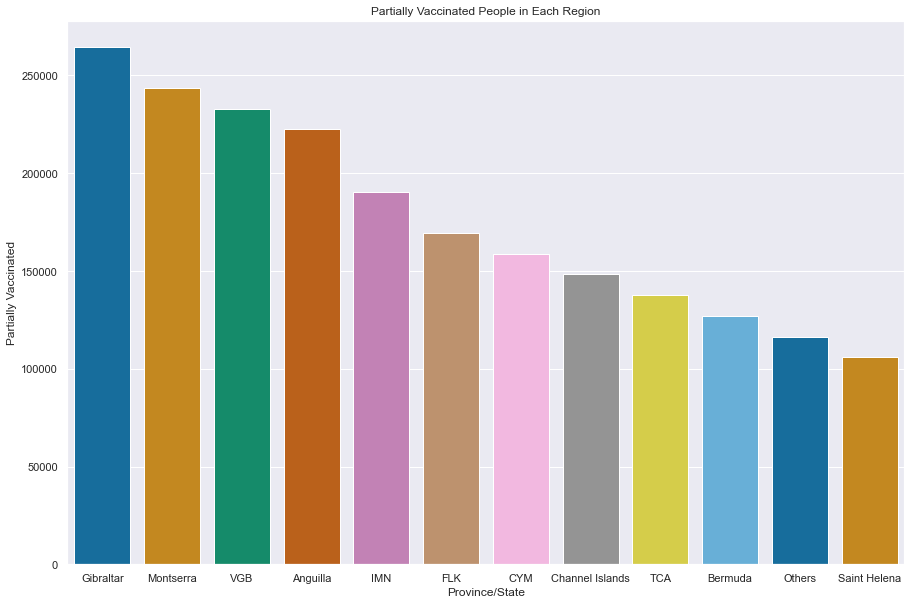

In [156]:
# Create Barplot showing Partially Vaccinated People in Each Region

dosebar = sns.barplot (x = 'Province/State', y = 'Difference', palette = 'colorblind', data = doseregion)

dosebar.set_xticklabels(['Gibraltar','Montserra','VGB', 'Anguilla', 'IMN', 'FLK', 'CYM','Channel Islands',
                        'TCA','Bermuda', 'Others', 'Saint Helena'])
dosebar.set_ylabel('Partially Vaccinated')
dosebar.set_title('Partially Vaccinated People in Each Region')


dosebar.figure.savefig('Partially Vaccinated Bar.png', dpi=144)



In [158]:
#Create new column where percent of people who have not taken second dose is calculated
doseregion['% W/O Second Dose'] = ((doseregion['Difference'] / doseregion['First Dose']*100)) 



doseregion
#Turks and Caicos Islands, Isle of Man, and British Virgin Islands have the highest percent of people who have/
#not taken a second dose. However difference in percentage is negligable.


,Province/State,First Dose,Second Dose,Difference,% W/O Second Dose
6,Gibraltar,5870786,5606041,264745,4.509532
8,Montserrat,5401128,5157560,243568,4.509577
2,British Virgin Islands,5166303,4933315,232988,4.509763
0,Anguilla,4931470,4709072,222398,4.509771
7,Isle of Man,4226984,4036345,190639,4.510048
5,Falkland Islands (Malvinas),3757307,3587869,169438,4.509560
3,Cayman Islands,3522476,3363624,158852,4.509669
4,Channel Islands,3287646,3139385,148261,4.509640
11,Turks and Caicos Islands,3052822,2915136,137686,4.510122
1,Bermuda,2817981,2690908,127073,4.509363


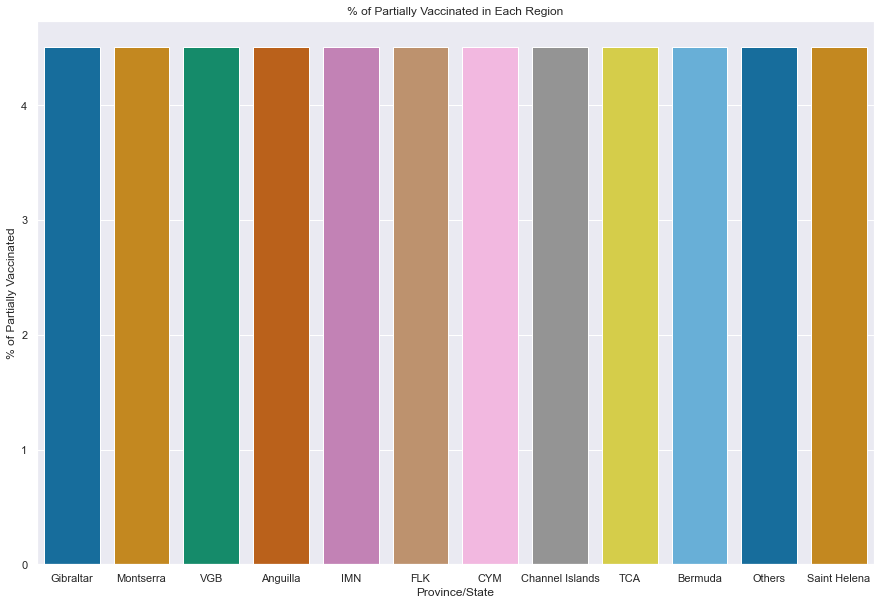

In [159]:
# Create Barplot showing the percentage of partially vaccinated people

dosebar1 = sns.barplot (x = 'Province/State', y = '% W/O Second Dose', palette = 'colorblind', data = doseregion)

dosebar1.set_xticklabels(['Gibraltar','Montserra','VGB', 'Anguilla', 'IMN', 'FLK', 'CYM','Channel Islands',
                        'TCA','Bermuda', 'Others', 'Saint Helena'])
dosebar1.set_ylabel('% of Partially Vaccinated')
dosebar1.set_title('% of Partially Vaccinated in Each Region')


dosebar1.figure.savefig('Partially Vaccinated % Bar.png', dpi=144)

Exploring how uptake of the first dose and second dose changes overtime will help understand how vaccines have been adminstered overtime.
A chart is created for Gibraltar as it was the region with the most partially vaccinated people.
A chart is created for all regions as well to compare

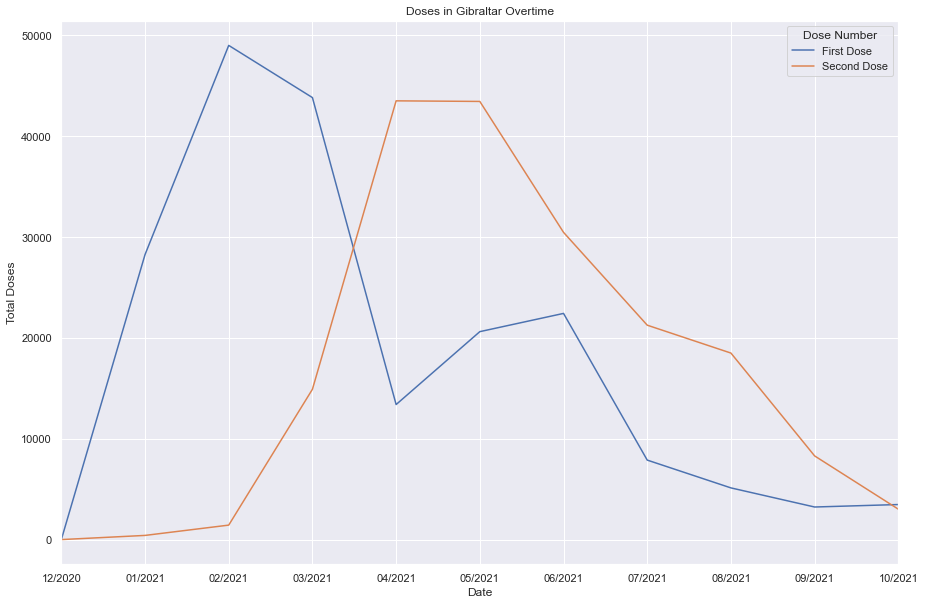

In [164]:
# Create Dataframe with information for 'Doses in Gibraltar overtime' graphic
gibraltardose = gibraltar[['DateMonth','First Dose','Second Dose']]

# Create a long version of the dataframe (Prefered format for SeaBorn)
gibraltardoselong = gibraltardose.melt(id_vars= 'DateMonth', var_name = "Dose Number", value_name = 'Dose Total')

# Create Lineplot for Doses in Gibraltar overtime 
gibplot = sns.lineplot (x ='DateMonth', y = 'Dose Total', hue= 'Dose Number', data = gibraltardoselong, ci = None)

# Format Lineplot
gibplot.set_xlim('12/2020','10/2021')
gibplot.set_xlabel ('Date')
gibplot.set_ylabel('Total Doses')
gibplot.set_title('Doses in Gibraltar Overtime')

# Export Lineplot
gibplot.figure.savefig('Gib Doses.png', dpi=144)

      DateMonth  Dose Number  Dose Total
15163   10/2021  Second Dose        1070
15164   10/2021  Second Dose        1300
15165   10/2021  Second Dose        1482
15166   10/2021  Second Dose           0
15167   10/2021  Second Dose           0


/var/folders/vm/m0mbrqn92kndn3vy7sxnktpm0000gn/T/ipykernel_39373/212363582.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  doseplot.set_yticklabels(['','0','2','4','6','8','10'])


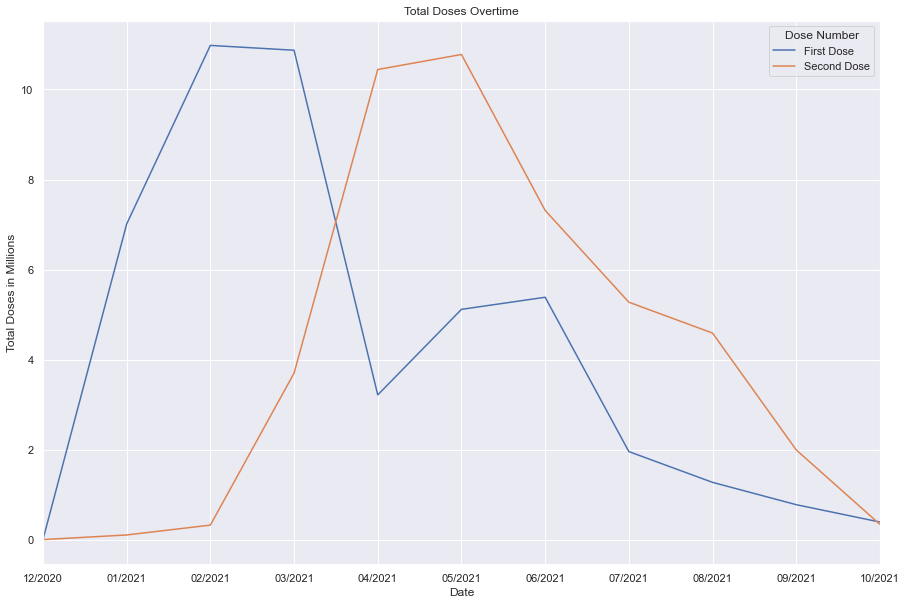

In [175]:
# Create Dataframe with information for ' Total Doses overtime' graphic
dosesovertime = covvac[['DateMonth','First Dose','Second Dose']]

# Create a long version of the dataframe (Prefered format for SeaBorn)
doseovertimelong = dosesovertime.melt(id_vars= 'DateMonth', var_name = "Dose Number", value_name = 'Dose Total')

# Create Lineplot for Total Doses Overtime 
doseplot = sns.lineplot (x ='DateMonth', y = 'Dose Total', hue= 'Dose Number', estimator=np.sum, 
                         data = doseovertimelong, ci = None)

# Format Lineplot
doseplot.set_xlim('12/2020','10/2021')
doseplot.set_xlabel ('Date')
doseplot.set_ylabel('Total Doses in Millions')
doseplot.set_title('Total Doses Overtime')
doseplot.set_yticklabels(['','0','2','4','6','8','10'])

# Export Lineplot
doseplot.figure.savefig('Total Doses.png', dpi=144)

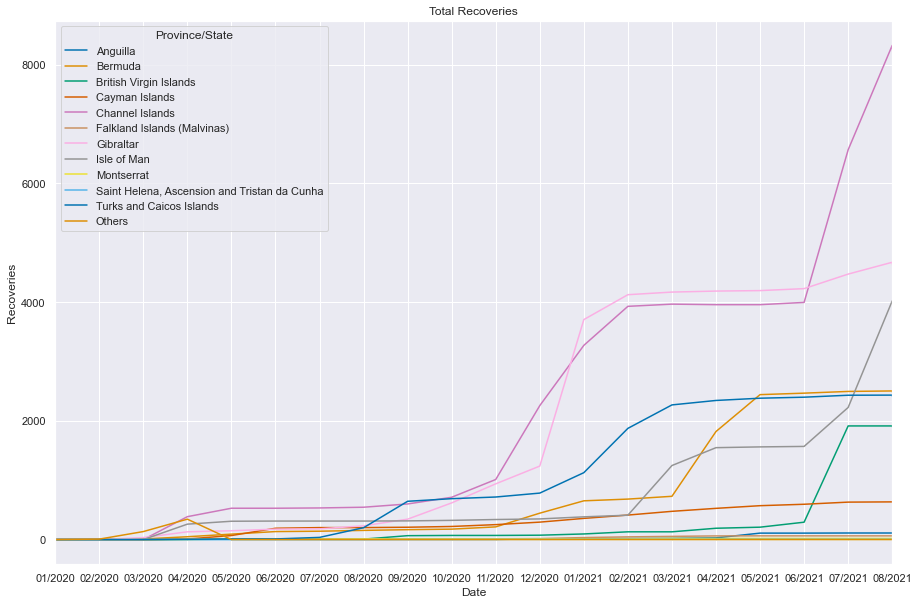

In [180]:
# Create a Lineplot showing recoveries over time
recoveredline = sns.lineplot (x='DateMonth', y='Recovered', data=covvac, estimator=np.max, hue = 'Province/State',
                   palette = 'colorblind', ci = None)

# Format Lineplot
recoveredline.set_xlim('01/2020','08/2021')
recoveredline.set_xlabel ('Date')
recoveredline.set_ylabel('Recoveries')
recoveredline.set_title('Total Recoveries')

#Export Lineplot
recoveredline.figure.savefig('Recoveries.png', dpi=144)

<AxesSubplot:xlabel='DateMonth', ylabel='Deaths'>

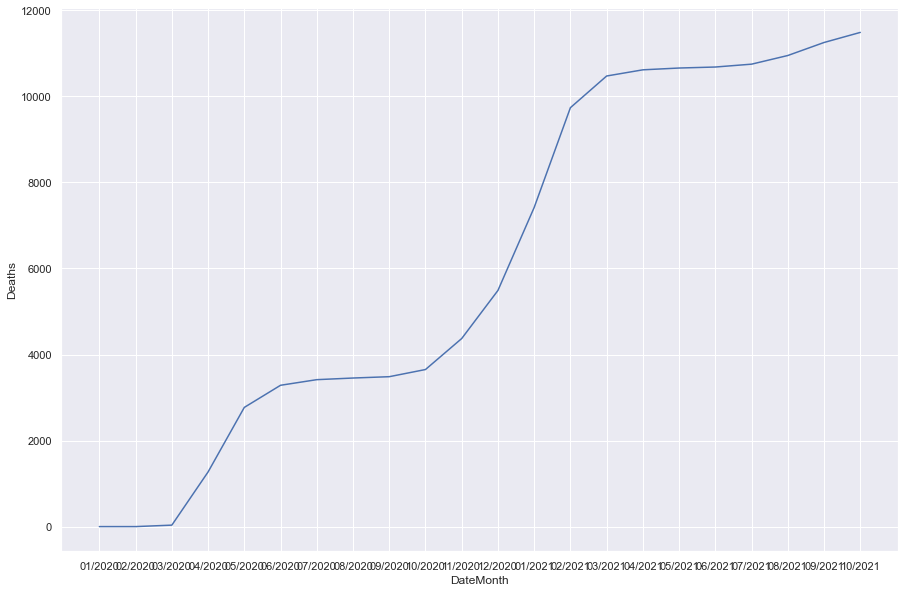

In [183]:
# Create Lineplot showing total deaths overtime for exploratory analysis
sns.lineplot (x='DateMonth', y='Deaths', data=covvac, ci = None)

<AxesSubplot:xlabel='DateMonth', ylabel='Deaths'>

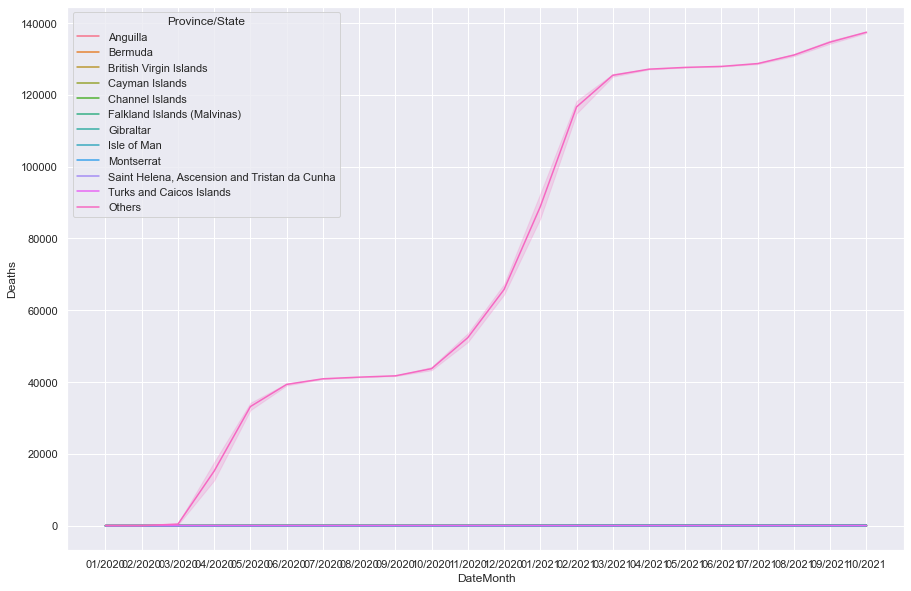

In [185]:
# Create Lineplot showing total deaths per region for exploratory analysis

sns.lineplot (x='DateMonth', y='Deaths', 
              data=covvac, hue = 'Province/State')

# Note how 'others' skews the data

/var/folders/vm/m0mbrqn92kndn3vy7sxnktpm0000gn/T/ipykernel_39373/396613715.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  deathsregion.set_xticklabels(['01/2020','','','04/2020','','','07/2020','','','10/2020','','','01/2021',


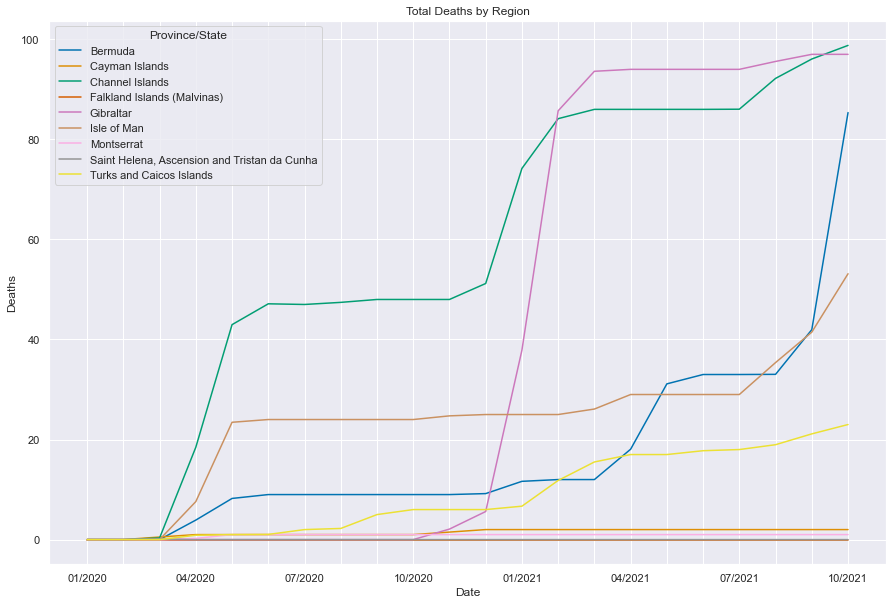

In [198]:
# Create chart of total deaths per region, excluding 'others'

deathsregion = sns.lineplot (x='DateMonth', y='Deaths', 
                                 data=covvac[covvac ['Province/State'].isin(['Anguilia','Bermuda','British VirginIslands',
                                                         'Cayman Islands', 'Channel Islands', 
                                                         'Falkland Islands (Malvinas)','Gibraltar','Isle of Man',
                                                         'Montserrat','Saint Helena, Ascension and Tristan da Cunha',
                                                         'Turks and Caicos Islands'])]
                                                         , hue = 'Province/State', palette = 'colorblind', ci= None)

# Format Lineplot
deathsregion.set_xticklabels(['01/2020','','','04/2020','','','07/2020','','','10/2020','','','01/2021',
                             '','','04/2021','','','07/2021','','','10/2021'])

deathsregion.set_xlabel ('Date')
deathsregion.set_ylabel('Deaths')
deathsregion.set_title('Total Deaths by Region')

#Export Lineplot
deathsregion.figure.savefig('Total Deaths by region.png', dpi=144)

/var/folders/vm/m0mbrqn92kndn3vy7sxnktpm0000gn/T/ipykernel_39373/2942169296.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  deathstot.set_xticklabels(['01/2020','','','04/2020','','','07/2020','','','10/2020','','','01/2021',


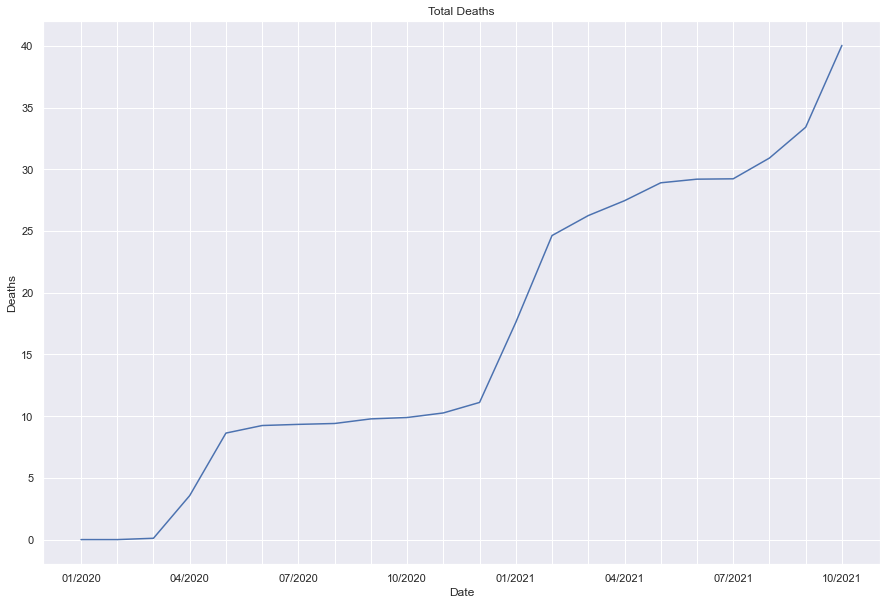

In [201]:
# Create chart of total deaths excluding 'others'
deathstot = sns.lineplot (x='DateMonth', y='Deaths', 
                                 data=covvac[covvac ['Province/State'].isin(['Anguilia','Bermuda','British VirginIslands',
                                                         'Cayman Islands', 'Channel Islands', 
                                                         'Falkland Islands (Malvinas)','Gibraltar','Isle of Man',
                                                         'Montserrat','Saint Helena, Ascension and Tristan da Cunha',
                                                         'Turks and Caicos Islands'])]
                                                         , palette = 'colorblind', ci= None)

# Format Lineplot
deathstot.set_xticklabels(['01/2020','','','04/2020','','','07/2020','','','10/2020','','','01/2021',
                             '','','04/2021','','','07/2021','','','10/2021'])
deathstot.set_xlabel ('Date')
deathstot.set_ylabel('Deaths')
deathstot.set_title('Total Deaths')

#Export Lineplot
deathstot.figure.savefig('Total Deaths.png', dpi=144)

## Part 2 - Trending Topics on Twitter

In [202]:
# Import Twitter Data
twitter = pd.read_csv('tweets.csv')

In [204]:
#Explore Twitter Data

print(twitter.shape)
print(twitter.dtypes)


(3960, 21)
created_at                    object
id                           float64
id_str                       float64
text                          object
truncated                     object
source                        object
in_reply_to_status_id        float64
in_reply_to_status_id_str    float64
in_reply_to_user_id          float64
in_reply_to_user_id_str      float64
in_reply_to_screen_name      float64
contributors                 float64
is_quote_status               object
retweet_count                  int64
favorite_count                 int64
favorited                     object
retweeted                     object
lang                          object
possibly_sensitive            object
quoted_status_id             float64
quoted_status_id_str         float64
dtype: object
   created_at            id        id_str  \
0  23/05/2022  1.528750e+18  1.528750e+18   
1  23/05/2022  1.528720e+18  1.528720e+18   
2  23/05/2022  1.528650e+18  1.528650e+18   
3  23/05/2022  1.5

In [205]:
# View Twitter Data

print(twitter.head())
print(twitter.tail())
# The text columns has the tweets and hashtags

   created_at            id        id_str  \
0  23/05/2022  1.528750e+18  1.528750e+18   
1  23/05/2022  1.528720e+18  1.528720e+18   
2  23/05/2022  1.528650e+18  1.528650e+18   
3  23/05/2022  1.528610e+18  1.528610e+18   
4  23/05/2022  1.528600e+18  1.528600e+18   

                                                text truncated  \
0  READ MY NEW OP-ED: IRREVERSIBLE – Many Effects...     False   
1  #COVID19 is linked to more #diabetes diagnoses...     False   
2  READ MY NEW OP-ED: IRREVERSIBLE – Many Effects...     False   
3  READ MY NEW OP-ED: IRREVERSIBLE – Many Effects...     False   
4  Advanced healthcare at your fingertips\nhttps:...     False   

                                              source  in_reply_to_status_id  \
0  <a href="https://www.socialjukebox.com" rel="n...                    NaN   
1  <a href="http://twitter.com/download/iphone" r...                    NaN   
2  <a href="https://www.socialjukebox.com" rel="n...                    NaN   
3  <a href="http

In [207]:
# Change Text Data Type to string
twitter ['text'] = twitter ['text'].astype(str)

#Strip Text Data
text = twitter['text'].apply(lambda x: x if x.strip() != None else N)

In [239]:
# Create Series with hashtags from Text
hashtags = []
for y in [x.split(' ') for x in text.values]:
    for z in y:
        if '#' in z:
            hashtags.append(z)
 

hashtags = pd.Series(hashtags).value_counts()

#Count each instance of each hashtag

In [235]:
# View Series

hashtags.head(30)

#COVID19                1632
#CovidIsNotOver          472
#China                   262
#covid19                 176
#Covid19                 148
#COVID                   108
#covid                   104
#Greece                  103
#coronavirus             100
#PeoplesVaccine.          84
#CoronaUpdate             84
#Omicron                  83
#COVID2020                82
#covid19uk                80
#CoronavirusOutbreak      80
#COVID19Pandemic          80
#monkeypox                77
#globalhealth             76
#publichealth             72
#COVID2019                69
#healthtech               69
#datascience              66
#data                     66
#analytics                64
#Shanghai                 63
#Covid_19                 63
#datavisualization        63
#pandemic                 60
#Athens                   55
#Beijing                  50
dtype: int64

In [243]:
# Convert Series to Dataframe
hashtagsdf = pd.DataFrame([hashtags]).reset_index()

In [248]:
# Transpose Dataframe to make it readable

hashtagsdf_transposed = df.T.reset_index()
hashtagsdf_transposed.head(5)


,index,0
0,index,0
1,#COVID19,1632
2,#CovidIsNotOver,472
3,#China,262
4,#covid19,176


In [259]:
# Change Column Names
hashtagsdf_transposed.columns = ['hashtag','count']
hashtagsdf_transposed.head(31)

,hashtag,count
0,index,0
1,#COVID19,1632
2,#CovidIsNotOver,472
3,#China,262
4,#covid19,176
5,#Covid19,148
6,#COVID,108
7,#covid,104
8,#Greece,103
9,#coronavirus,100


In [292]:
# Filter out non-trending hashtags
hashtag99 = hashtagsdf_transposed[hashtagsdf_transposed['count'] >99]
hashtag99

,hashtag,count
1,#COVID19,1632
2,#CovidIsNotOver,472
3,#China,262
4,#covid19,176
5,#Covid19,148
6,#COVID,108
7,#covid,104
8,#Greece,103
9,#coronavirus,100


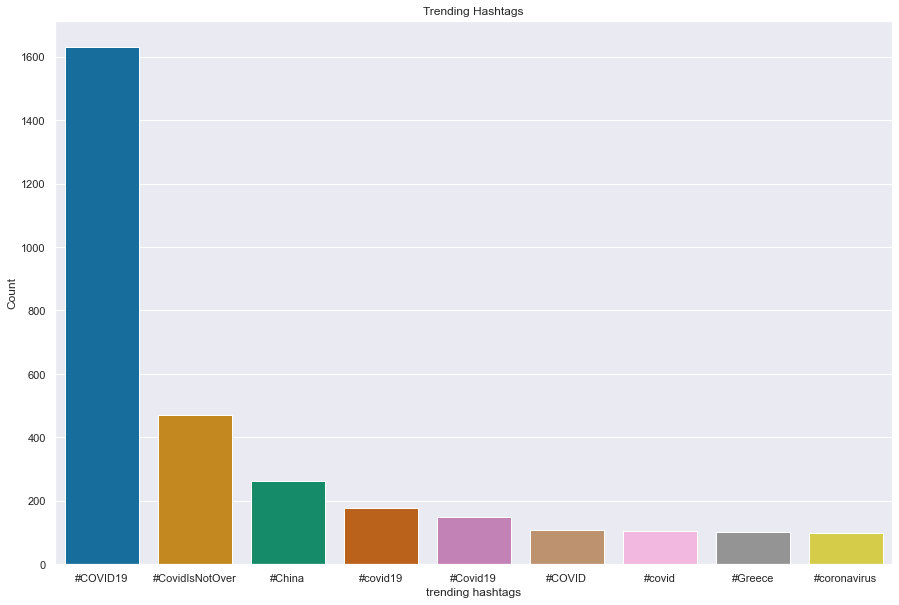

In [272]:
# Create Barplot with twitter trending topics
twittergraph = sns.barplot (x = 'hashtag', y = 'count', data = hashtag99, palette = 'colorblind')

# Format Barplot
twittergraph.set_xlabel ('trending hashtags')
twittergraph.set_ylabel('Count')
twittergraph.set_title('Trending Hashtags')

# Export Barplot
twittergraph.figure.savefig('Treding Hashtags.png', dpi=144)

## Part 3 - Predicting Hospitalisations
Some of the below code is taken from work of a previous consultant. The code can show if hospitalisations have peaked, and give an indicatation if hospitalisations are about to peak.

In [273]:
# Create Dataframe with needed columns for Time-Series Analysis
sample = covvac[['Province/State','Date','Hospitalised']]

In [274]:
# Per governments request, analysis will focus only on Channel Islands
sample_ci = sample[sample['Province/State'] == "Channel Islands"]

In [279]:
#The below code is from the consultant
# Define function to plot moving averages
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    
    # Create a rolling window to calculate the rolling mean using the series.rolling function
    rolling_mean = series.rolling(window=window).mean()
    
    # Declare the dimensions for the plot, plot name and plot the data consisting of the rolling mean from above 
    plt.figure(figsize=(18,4))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Simple moving average trend')

    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        
        # Calculate the mean absolute square 
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        
        # Calculate the standard deviation using numpy's std function
        deviation = np.std(series[window:] - rolling_mean[window:])
        
        # Calculate the upper and lower bounds 
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        
        # Name and style upper and lower bound lines and labels 
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
    
    # Plot the actual values for the entire timeframe
    plt.plot(series[window:], label='Actual values')
    plt.grid(True)

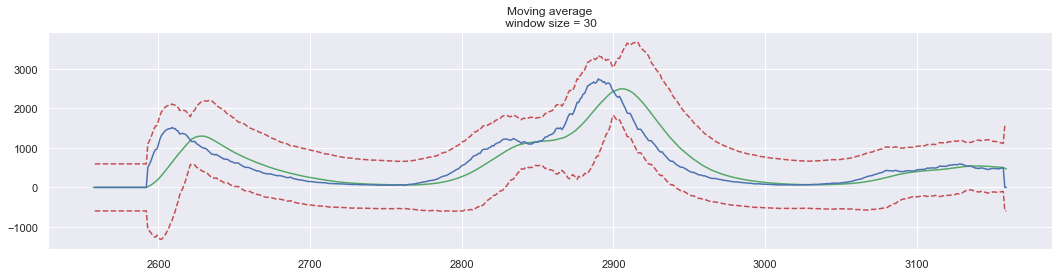

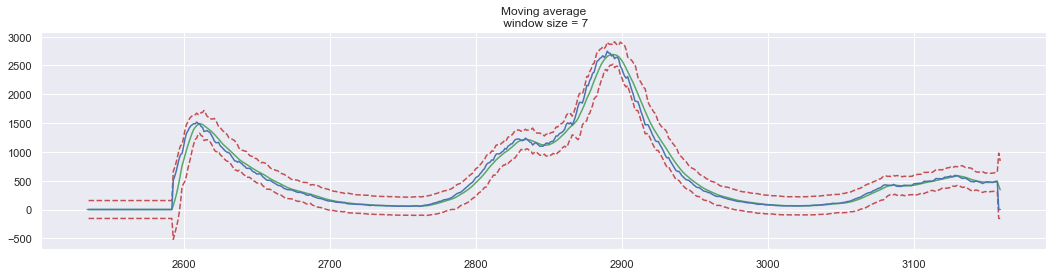

In [297]:
#Create plot showing time-series analysis with a 30 day rolling Average
# To change length of rolling average, replace the 30 will required amount
plot_moving_average(sample_ci.Hospitalised, 30, plot_intervals=True)
plot_moving_average(sample_ci.Hospitalised, 7, plot_intervals=True)
